<a href="https://colab.research.google.com/github/johannes-kk/am207/blob/master/exercises/03_beta_binomial_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DAY 3: The Beta-Binomial Model


### AM207: Advanced Scientific Computing

#### Instructor: Weiwei Pan

#### Due: September 10th, 11:59pm EST

**Names of Group Members**:  
David Ma david_ma@college.harvard.edu <br/>
Elaine Cunha mcunha@g.harvard.edu <br/>
Maggie Wang maggiewang@college.harvard.edu <br/>
Gabriel Pestre gpestre@g.harvard.edu <br/>
Johannes Kolberg johanneskolberg@g.harvard.edu <br/>
Nayantara Mudur nmudur@g.harvard.edu<br/>

## Learning Goals:

1. be able to apply Beta-Binomial models to determine fair rankings 
2. understand the effect of the prior and evidence in this model
3. be able to interpret the prior and posterior as real-life beliefs

### Load necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import mode
from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### We include auxiliary functions here that we will need to use later 

In [ ]:
def movie_stats(names_df,
                ratings_df,
                movie_name=None,
                movie_name_contains=None,
                verbose=False):
    '''--------  movie_stats
    A function that extracts the total number of ratings and number of likes for a movie
    Input: 
         movie_name (an optional parameter containing the exact name of the movie)
         movie_name_contains (an optional parameter containing part of the movie name)
    Returns: 
         total_ratings (the total number of ratings for a movie)
         likes (the total number of likes for a movie)
    '''
    
    #If given an exact movie name:
    if movie_name is not None:        
        #Find the index of the movie, by name, in the "names" dataframe
        movie_index = names_df[names_df['movie_name'] == movie_name].index[0]
        #Get the id for the movie in the "names" dataframe
        movie_id = names_df.loc[movie_index, 'movie_id']
        #Get all ratings for the movie, by id, in the "ratings" dataframe
        ratings_for_movie = ratings_df[ratings_df['movie_id'] == movie_id]
        #Count the total number of ratings
        total_ratings = len(ratings_for_movie)
        #Count the likes (the 1's)
        likes = ratings_for_movie['rating'].sum()
    
    #Otherwise, if given a partial movie name:
    elif movie_name_contains is not None:
        #Find the index of the movie, by name, in the "names" dataframe
        movie_index = names_df[names_df['movie_name'].str.contains(movie_name_contains,case=False)].index[0]
        if verbose: print(names_df['movie_name'][movie_index])
        #Get the id for the movie in the "names" dataframe
        movie_id = names_df.loc[movie_index, 'movie_id']
        #Get all ratings for the movie, by id, in the "ratings" dataframe
        ratings_for_movie = ratings_df[ratings_df['movie_id'] == movie_id]
        #Count the total number of ratings
        total_ratings = len(ratings_for_movie)
        #Count the likes (the 1's)
        likes = ratings_for_movie['rating'].sum()
    
    else:
        total_ratings = 0.
        likes = 0.
    
    return float(total_ratings), likes


def generate_list_top_movies(names_df, ratings_df, n_movies=25):
    '''--------  generate_list_top_movies
    A function that makes a list of movie names and their ratings info,
    based on like-percentage only
    Input: 
         names_df (a dataframe containing the names of the movie)
         ratings_df (a dataframe containing the movie ratings)
         n_movies (an optional parameter indicating the number of movies to return)
    Returns: 
         top_movies (the top movies ranked by like-percentage)
    '''

    likability = []

    #Iterate through all the movie names
    for name in names_df['movie_name'].values:
        #Get ratings info for movie
        total_ratings, likes = movie_stats(names_df, ratings_df, movie_name=name)
        #Add movie info to our list
        likability.append((name, likes, total_ratings, likes / total_ratings))

    #Sort our list of movie info by like-percentage, in descending order
    sorted_likability = sorted(likability, key=lambda t: t[3], reverse=True)  
    #Get the movies with top 25 like-percentage
    top_movies = sorted_likability[:n_movies]

    #Print results of ranking
    print('Top %d Movies' % n_movies)
    print('****************************')
    for movie, likes, total_ratings, likable in top_movies:
        print(movie, ':', likable, '({}/{})'.format(likes, total_ratings))
    return top_movies


def plot_beta_prior(a, b, color, ax):
    '''--------  plot_beta_prior
    A function to visualize a beta pdf on a set of axes
    Input: 
         a (parameter controlling shape of beta prior)
         b (parameter controlling shape of beta prior)
         color (color of beta pdf)
         ax (axes on which to plot pdf)
    Returns: 
         ax (axes with plot of beta pdf)
    '''
    
    #Create a beta-distributed random variable with shape a, b
    rv = sp.stats.beta(a, b)
    #Create values from 0 to 1
    x = np.linspace(0, 1, 100)
    #Plot the beta pdf for values from 0 to 1
    ax.plot(x, rv.pdf(x), '-', lw=2, color=color, label='a=' + str(a) + ', b=' + str(b))
    #Set title, legend etc
    ax.set_title('Beta prior with a=' + str(a) + ', b=' + str(b))
    ax.legend(loc='best')
    
    return ax


def sample_posterior(a, b, likes, ratings, n_samples):
    '''--------  sample_posterior
    A function that samples points from the posterior over a movie's 
    likability, given a binomial likelihood function and beta prior
    Input: 
         a (parameter controlling shape of beta prior)
         b (parameter controlling shape of beta prior)
         likes (the number of likes in likelihood)
         ratings (total number of ratings in likelihood)
         n_samples (number of samples to take from posterior)
    Returns: 
         post_samples (a array of points from the posterior)
    '''
    #Samples points from a beta distribution 
    #(the posterior of a binomial likelihood and a beta prior is a beta distribution!)
    post_samples = np.random.beta(a + likes, b + ratings - likes, n_samples)
    return post_samples


def find_mode(values, num_bins):
    '''--------  find_mode
    A function that approximates the mode of a distribution given a sample from the distribution
    Input: 
         values (samples from the distribution)
         num_bins (number of bins to use in approximating histogram)
    Returns: 
         mode (the approximate mode of the distribution)
    '''
    
    #Make an approximation (histogram) of the distribution using the samples
    bins, edges = np.histogram(values, bins=num_bins)
    #Find the bin in the histogram with the max height
    max_height_index = np.argmax(bins)
    #Find the sample corresponding to the bin with the max height (the mode)
    mode = (edges[max_height_index] + edges[max_height_index + 1]) / 2.
    
    return mode

# Application: building a ranking system of movies based on ratings

The objective is to build a ranking system to recommend movies using ratings from users.

One way of recommending movies is to give a list of movies that are generally agreed upon to be good. But how do we measure the "goodness" or "likability" of a movie?

### Read the data and explore

The dataset for this problem is contained in `ratings_df` (below). This dataset contains ratings from 100 users for 1000 movies. The first two columns contain the user and movie IDs. The last column contains a 1 if the user liked the movie, and 0 otherwise. Not every movie is rated by every user (i.e. some movies have more ratings than others).

The names of the movies corresponding to the IDs are provided in `names.df` (below).

Let's first read in the data in the csv file and get acquainted with our data.

In [ ]:
# read in the movie ratings data from a csv file
ratings_df = pd.read_csv('https://raw.githubusercontent.com/onefishy/am207/master/Labs/datasets/ratings.txt', delimiter=',')
# print out the first 5 rows of the dataframe
ratings_df.head()

,user_id,movie_id,rating
0,22.0,377.0,0.0
1,62.0,257.0,0.0
2,95.0,546.0,0.0
3,38.0,95.0,1.0
4,63.0,277.0,1.0


In [ ]:
# read in the movie names form a csv file
names_df = pd.read_csv('https://raw.githubusercontent.com/onefishy/am207/master/Labs/datasets/movie_names.txt')
# print out the first 5 rows of the dataframe
names_df.head()

,movie_id,movie_name
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


### Rank movies based on number of positive ratings ("likes")

Let's compare the number of total ratings and "likes" for a couple of movies.

**Exercise 1:** Examine the number of total ratings and "likes" for the following movies:
* `Batman Forever (1995)`
* `Unhook the Stars (1996)`
* `Shawshank Redemption, The (1994)`

To help you, the following helper function `compute_n_ratings_and_likes` takes a movie name, and returns total number of ratings, and total number of positive ratings ("likes").

Based on the total number of "likes", which of the following movies would you recommend? Is this a fair ranking system?

In [ ]:
# call the following function to extract the information
def compute_movie_stats(movie_name=None, movie_name_contains=None):
    total_ratings, likes = movie_stats(names_df, ratings_df,
        movie_name=movie_name, movie_name_contains=movie_name_contains, verbose=True)
    print('total number of ratings:', total_ratings)
    print('number of likes:', likes,'\n')
    return total_ratings, likes

In [ ]:
# Example: print the number of ratings and likes for Batman
_, _ = compute_movie_stats(movie_name_contains='batman')
_, _ = compute_movie_stats(movie_name_contains='unhook')
_, _ = compute_movie_stats(movie_name_contains='shawshank')

Batman Forever (1995)
total number of ratings: 10.0
number of likes: 1.0 

Unhook the Stars (1996)
total number of ratings: 1.0
number of likes: 1.0 

Shawshank Redemption, The (1994)
total number of ratings: 39.0
number of likes: 39.0 



**Answer:** We'd recommend Shawshank as it has the highest number of ratings. This is not necessarily a fair system as the movies with the most views, provided it is not awful, will tend to be the top recommendation.

### Rank movies based on percentage of likes

Now, instead of using the total number of likes, we use the total percentage of likes to rank the movies. Each movie will have a *score* associated:
$$ score =\frac{ n_{likes}}{ n_{ratings}} \in [0,1]$$
Note that this percentage is the the MLE of the probability of a user liking a movie in a binomial model for the data. That is, we model the number of likes $n_{likes}$ as

$$
n_{likes} \sim Bin(n_{ratings}, \theta).
$$

Thus, $\theta_{\mathrm{MLE}} = \frac{ n_{likes}}{ n_{ratings}}$.

**Exercise 2:** Print out the top 25 movies ranked by the like-percentage. Do you feel like this list best represents the most "popular" or "beloved" movies in the database? Is this a fair ranking system?

In [ ]:
# Generate top-list of movies
top_25_movies = generate_list_top_movies(names_df, ratings_df, n_movies=25)

Top 25 Movies
****************************
French Twist (Gazon maudit) (1995) : 1.0 (2.0/2.0)
Exotica (1994) : 1.0 (2.0/2.0)
Three Colors: Red (1994) : 1.0 (12.0/12.0)
Three Colors: White (1994) : 1.0 (8.0/8.0)
Shawshank Redemption, The (1994) : 1.0 (39.0/39.0)
Brother Minister: The Assassination of Malcolm X (1994) : 1.0 (1.0/1.0)
Carlito's Way (1993) : 1.0 (4.0/4.0)
Robert A. Heinlein's The Puppet Masters (1994) : 1.0 (2.0/2.0)
Horseman on the Roof, The (Hussard sur le toit, Le) (1995) : 1.0 (2.0/2.0)
Wallace & Gromit: The Best of Aardman Animation (1996) : 1.0 (6.0/6.0)
Maya Lin: A Strong Clear Vision (1994) : 1.0 (1.0/1.0)
Unhook the Stars (1996) : 1.0 (1.0/1.0)
Wrong Trousers, The (1993) : 1.0 (14.0/14.0)
Godfather: Part II, The (1974) : 1.0 (18.0/18.0)
Ridicule (1996) : 1.0 (5.0/5.0)
Pillow Book, The (1995) : 1.0 (2.0/2.0)
When the Cats Away (Chacun cherche son chat) (1996) : 1.0 (3.0/3.0)
unknown : 1.0 (2.0/2.0)
Once Upon a Time... When We Were Colored (1995) : 1.0 (2.0/2.0)
Ass

**Answer:** Does not necessarily represen the most popular or beloved movie. For instance, a fringe movie could get a handful of reviews by its most ardent fans, which would make its positive rating percentage unusually high.

### Exploring the effect of prior beliefs

Recall that we can bias our models (if we don't like their results) by building in some prior beliefs about the model parameters. In this case, our model parameter is "the likability of a movie". So let's encode some prior beliefs for what we think are reasonable values for "likability". To keep things simple, we will restrict ourselves to using beta priors to model our beliefs about "likability".

We have built for you a few helpful functions: one to help you visualize the pdf for various beta priors, one for approximating the posterior using samples, and one for calculating the mode of a distribution (given by some sampled values).

First, let's explore the shapes of various beta pdfs and let's interpret these shapes as prior beliefs.

**Exercise 3:** The following is a set of five differe beta distributions. Describe in words what prior belief about the movie corresponds to each prior. Which beta prior encodes an appropriate belief about likability? Why?

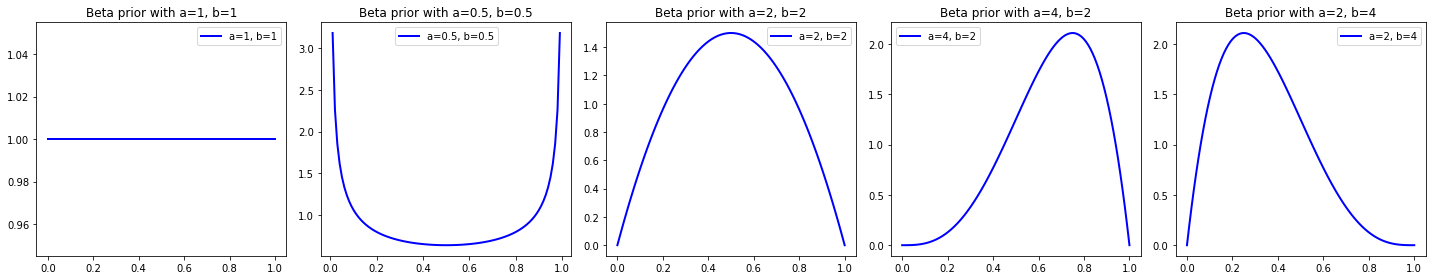

In [ ]:
# A list of beta distribution shapes to try out 
# (feel free to change the parameters of the beta distribution to explore their effects)
beta_shapes = [(1, 1), (0.5, 0.5), (2, 2), (4, 2), (2, 4)]

# Length of the list of shapes
n = len(beta_shapes)

# Plot all the beta pdfs in a row
fig, ax = plt.subplots(1, n, figsize=(20, 4))

# Start the index of the current subplot at 0
ax_ind = 0

# Iterate through all the shapes
for a, b in beta_shapes:
    # Plot the beta pdf for a particular shape
    plot_beta_prior(a, b, 'blue', ax[ax_ind])

    # Increment the subplot index
    ax_ind += 1
    
plt.tight_layout()    
plt.show() 

**Answer**:
1. No prior belief about the likability; all percentages of positive reviews are equally likely.
2. Either not likeable or very likeable, no middle ground.
3. Expect overall likeability to be in the middle ground, i.e. all viewers are only adequately satisfied.
4. Such a prior would represent a positive selection bias in the pool of reviewers. We believe that people who provide ratings are likely to like to provide positive ratings or the reviewers are generally happy with the films they review
5. Such a prior would represent a negative selection bias in the pool of reviewers, We believe that people providing ratings are likely harsh critics and are more likely to not give films a positive rating.

The latter three seem most reasonable.


Let's then look at the effect of the priors on the posterior of likability for a specific movie.

**Exercise 4:** For a couple of movies, print out the posterior of the Beta-Binomial model for each of five priors in Exercise 3. 

Describe what belief about the movie corresponds to each posterior.

Describe the effect of the prior on the posterior distribution. 

Compare the posteriors for a couple of movies (e.g. "Shawshank Redemption", "French Twist"), explain why the posteriors for these movies look different when the same priors are used. Relate your answers to the concepts from lecture.

In [ ]:
i = 3

# Example: Get the name of the first movie in the previous top-25 list
movie_name = top_25_movies[i][0]

# Get the ratings info for the first movie in the top 25 list
likes = top_25_movies[i][1]
total_ratings = top_25_movies[i][2]
likability = top_25_movies[i][3]

# Print movie info
print('{}: {} ({}/{})'.format(movie_name, likability, likes, total_ratings))

Three Colors: White (1994): 1.0 (8.0/8.0)


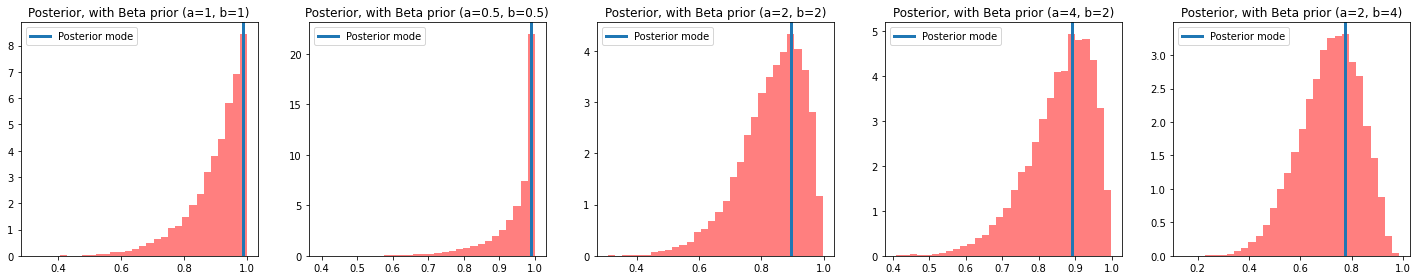

In [ ]:
# Number of samples to use when approximating our posterior
n_samples = 10000
n = 5

# Plot the posterior corresponding to each prior
fig, ax = plt.subplots(1, n, figsize=(20, 4))

# Start the index of the current subplot at 0
ax_ind = 0

# Iterate through all the shapes
for a, b in beta_shapes:   
    # Draw samples from the posterior corresponding to a particular beta prior
    post_samples = sample_posterior(a, b, likes, total_ratings, n_samples)

    # Approximate the posterior with a histogram of these samples
    ax[ax_ind].hist(post_samples, bins=30, color='red', alpha=0.5, density = True)

    # Find the approximate mode of the posterior
    mode = find_mode(post_samples, 30)

    # Plot the mode as a vertical line
    ax[ax_ind].axvline(x=mode, linewidth=3, label='Posterior mode')
    
    # Set title, legends etc
    ax[ax_ind].set_title('Posterior, with Beta prior (a={}, b={})'.format(a, b))
    ax[ax_ind].legend(loc='best')

    # Increment the subplot index
    ax_ind += 1

plt.tight_layout()
plt.show() 

In [ ]:
i = 0

# Example: Get the name of the first movie in the previous top-25 list
movie_name = top_25_movies[i][0]

# Get the ratings info for the first movie in the top 25 list
likes = top_25_movies[i][1]
total_ratings = top_25_movies[i][2]
likability = top_25_movies[i][3]

# Print movie info
print('{}: {} ({}/{})'.format(movie_name, likability, likes, total_ratings))

French Twist (Gazon maudit) (1995): 1.0 (2.0/2.0)


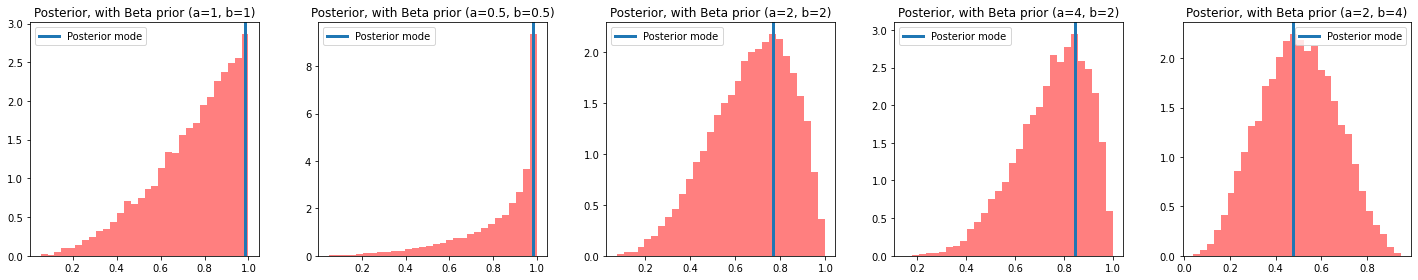

In [ ]:
# Number of samples to use when approximating our posterior
n_samples = 10000
n = 5

# Plot the posterior corresponding to each prior
fig, ax = plt.subplots(1, n, figsize=(20, 4))

# Start the index of the current subplot at 0
ax_ind = 0

# Iterate through all the shapes
for a, b in beta_shapes:   
    # Draw samples from the posterior corresponding to a particular beta prior
    post_samples = sample_posterior(a, b, likes, total_ratings, n_samples)

    # Approximate the posterior with a histogram of these samples
    ax[ax_ind].hist(post_samples, bins=30, color='red', alpha=0.5, density = True)

    # Find the approximate mode of the posterior
    mode = find_mode(post_samples, 30)

    # Plot the mode as a vertical line
    ax[ax_ind].axvline(x=mode, linewidth=3, label='Posterior mode')
    
    # Set title, legends etc
    ax[ax_ind].set_title('Posterior, with Beta prior (a={}, b={})'.format(a, b))
    ax[ax_ind].legend(loc='best')

    # Increment the subplot index
    ax_ind += 1

plt.tight_layout()
plt.show() 

In [ ]:
i = 4

# Example: Get the name of the first movie in the previous top-25 list
movie_name = top_25_movies[i][0]

# Get the ratings info for the first movie in the top 25 list
likes = top_25_movies[i][1]
total_ratings = top_25_movies[i][2]
likability = top_25_movies[i][3]

# Print movie info
print('{}: {} ({}/{})'.format(movie_name, likability, likes, total_ratings))

Shawshank Redemption, The (1994): 1.0 (39.0/39.0)


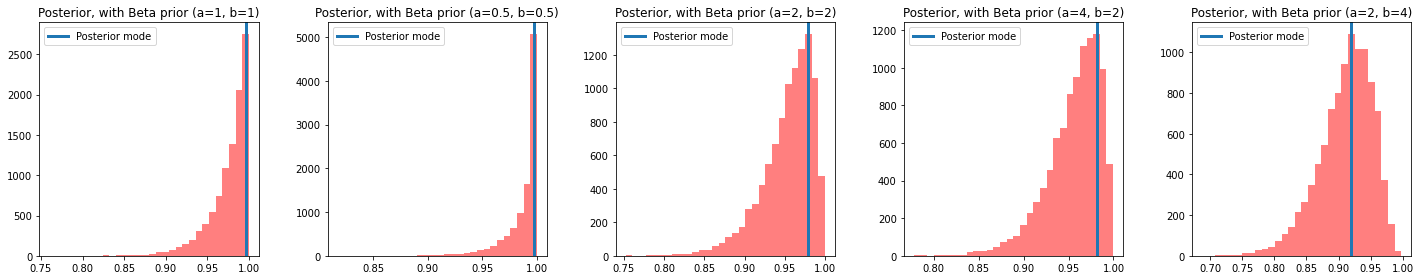

In [ ]:
# Number of samples to use when approximating our posterior
n_samples = 10000
n = 5

# Plot the posterior corresponding to each prior
fig, ax = plt.subplots(1, n, figsize=(20, 4))

# Start the index of the current subplot at 0
ax_ind = 0

# Iterate through all the shapes
for a, b in beta_shapes:   
    # Draw samples from the posterior corresponding to a particular beta prior
    post_samples = sample_posterior(a, b, likes, total_ratings, n_samples)

    # Approximate the posterior with a histogram of these samples
    ax[ax_ind].hist(post_samples, bins=30, color='red', alpha=0.5)

    # Find the approximate mode of the posterior
    mode = find_mode(post_samples, 30)

    # Plot the mode as a vertical line
    ax[ax_ind].axvline(x=mode, linewidth=3, label='Posterior mode')
    
    # Set title, legends etc
    ax[ax_ind].set_title('Posterior, with Beta prior (a={}, b={})'.format(a, b))
    ax[ax_ind].legend(loc='best')

    # Increment the subplot index
    ax_ind += 1

plt.tight_layout()
plt.show() 

*Describe what belief about the movie corresponds to each posterior.*

**Answer:**  
1. Mode prediction is $~1.0$, so despite the uninformative prior the posterior is that likeability is almost at max.
2. Same. The prior was highly binary, so compared to a naive prior we believe even more strongly in universal likability.
3. Strongly believing in mediocre likability reduces the mode posterior, having skewed it more to the right due to our relatively strong prior belief.
4. Practically the same as 3.
5. The prior is still having an effect by assuming generally low likability, which skews the posterior somewhat to the right.

*Describe the effect of the prior on the posterior distribution.*

The distributons express how strong our beliefs are. Stronger priors influence the distribution of the posterior, particularly when the prior is "confirmed" by the data, such as having a strong belief of universally low or high likability (binary, one or the other) making the posterior for Shawshank essentially completely focused around high likability.

*Compare the posteriors for a couple of movies (e.g. "Shawshank Redemption", "French Twist"), explain why the posteriors for these movies look different when the same priors are used. Relate your answers to the concepts from lecture.*

In our comparison of the posterior between different movies, we see that the posterior for French Twist, which has only 2 ratings, is very prior-dominated as the mode shifts from 0.4 to 1.0. In the case of the Shawshank Redemption, the mode is always greater than 0.95, irrespective of the choice of prior.


### Implement a ranking system that takes prior beliefs into account

Let's **choose** a reasonable beta prior and build a list of top 25 movies that you would recommend to a new user based on the **posterior mode**.

**Exercise 6:**
In what important ways is our top 25 list using the posterior mode different from our top 25 list using the like-percent?

Describe the possible benefits of using the posterior mode to rank movies instead of the like-percentage. 

Describe the possible draw-backs of using the posterior mode to rank movies. 

In [ ]:
# Step 1: Choose a beta prior that encodes a reasonable belief about likability 
a = 2 
b = 2

# Step 2: Make a list of movie names and their ratings info
likability = []

# Step 3: Iterate through all the movie names
for name in names_df['movie_name'].values:
    # Step 3a: Get ratings info for movie
    total_ratings, likes = movie_stats(names_df, ratings_df, movie_name=name)

    # Step 3b: Approximate the posterior given the ratings info and the prior
    post_samples = sample_posterior(a, b, likes, total_ratings, n_samples)

    # Step 3c: Approximate posterior mode
    mode = find_mode(post_samples, 30)

    # Step 3d: Add movie info to our list
    likability.append((name, likes, total_ratings, mode))

# Step 4: Sort our list of movie info by like-percentage, in descending order
sorted_likability = sorted(likability, key=lambda t: t[3], reverse=True)  

# Step 5: Get the movies with top 25 like-percentage
top_25_movies = sorted_likability[:25]

# Step 6: Print results of ranking
print('Top 25 Movies')
print('****************************')
for movie, likes, total_ratings, likable in top_25_movies:
    print(movie, ':', likable, '({}/{})'.format(likes, total_ratings))

Top 25 Movies
****************************
Shawshank Redemption, The (1994) : 0.9777988970371516 (39.0/39.0)
Cool Hand Luke (1967) : 0.9525181366552535 (20.0/20.0)
Godfather: Part II, The (1974) : 0.9459120852911916 (18.0/18.0)
Glory (1989) : 0.9453069161635654 (17.0/17.0)
Raiders of the Lost Ark (1981) : 0.9387219008474446 (47.0/49.0)
Three Colors: Red (1994) : 0.9354335375884073 (12.0/12.0)
Killing Fields, The (1984) : 0.9346811505491587 (14.0/14.0)
Manchurian Candidate, The (1962) : 0.9324294995549689 (17.0/17.0)
Thin Man, The (1934) : 0.9242073018504269 (8.0/8.0)
Local Hero (1983) : 0.9237056410109945 (10.0/10.0)
Vertigo (1958) : 0.9214903049648107 (22.0/23.0)
High Noon (1952) : 0.9212004335866694 (11.0/11.0)
Wrong Trousers, The (1993) : 0.9180192845403112 (14.0/14.0)
Casablanca (1942) : 0.9102207510516964 (22.0/23.0)
Magnificent Seven, The (1954) : 0.9097694648351982 (14.0/15.0)
Dead Man Walking (1995) : 0.9042310013535506 (33.0/36.0)
Usual Suspects, The (1995) : 0.903723657901251

---

**Answer:**

*In what important ways is our top 25 list using the posterior mode different from our top 25 list using the like-percent?*

It does not overwhelm the Top 25 list with niche movies with few reviews. At the same time, for movies with fewer ratings it's therefore also harder to override the strong prior of some unlikability, so it will take a while for new or less popular movies to enter into the Top 25 list.

*Describe the possible benefits of using the posterior mode to rank movies instead of the like-percentage.*

The posterior mode is an attempt at balancing the proportion of positive reviews against the number of reviews. Consequently, the Top 25 list is more stable over time, rather than quickly changing if a new popular movie comes out. I.e. less sensitive to outliers.

*Describe the possible draw-backs of using the posterior mode to rank movies.*

While we have chosen a convenient conjugate prior, sometimes the posterior is not in a closed form. Furthermore, posterior mode does not account for any potential biases in our data: so depending on the database or user demographics, the movie ratings may reflect only a subset of the population and the posterior mode has no way to account for these biases. Further, it is extremely sensitive to data with high frequency, but this does not account for potential viral backlash to a film (i.e., the recent Star Wars) where automated bots could tank the score of a film. As such, the quality of the posterior is highly dependent on the quality of the data. 